# Al Jazeera English Webscraping Analysis

In [ ]:
import pandas as pd
import csv
import re
import matplotlib.pylab as plt
import numpy as np
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
plt.style.use('ggplot')

In [2]:
%matplotlib inline

### File Merging

In [3]:
#merged multiple .csv files into single dataframe and make copy for subsequent manipulations
df_original = pd.concat(map(pd.read_csv, ['al_jazeera_final_temp.csv', 'al_jazeera_final_temp_2.csv','al_jazeera_final_temp_3.csv', 'al_jazeera_final_temp_4.csv', 'al_jazeera_final_temp_5.csv']))
df = df_original.copy()
df.shape

(983, 7)

In [4]:
df.dtypes

title       object
header      object
caption     object
category    object
authors     object
datetime    object
article     object
dtype: object

In [5]:
df.head()

,title,header,caption,category,authors,datetime,article
0,Muqtada al-Sadr's double game,The Iraqi Shia leader has been playing a doubl...,Iraqi Shia cleric Moqtada al-Sadr has played a...,IRAQ,Hiwa Osman,Sun Feb 09 2020 13:00:54 GMT+0000,150 people were killed rejected The views expr...
1,Sinophobia won't save you from the coronavirus,The anti-Chinese racism in the wake of the cor...,Pedestrians walk in the Chinatown district of ...,US & CANADA,Edward Hon-Sing Wong,Sat Feb 08 2020 21:02:18 GMT+0000,That the video was shot on the Pacific island ...
2,Beware of digital populism,The new brand of populism which bases its poli...,"Co-founder Beppe Grillo, Davide Casaleggio, so...",DATA,Santiago Zabala,Fri Feb 07 2020 17:07:13 GMT+0000,"In recent years, right-wing populists have tak..."
3,Patriotism is racist,'True patriotism' and 'good patriotism' are ha...,A partially burned American flag lies on the s...,UNITED STATES,Yannick Giovanni Marshall,Thu Feb 06 2020 10:29:26 GMT+0000,On On Liberals rush to exclude from their tall...
4,Rohingya justice: Why the ICJ's public rebuke ...,The ICJ's order that Myanmar does all it can t...,Gambian Justice Minister Abubacarr Tambadou an...,MYANMAR,Tun Khin,Fri Feb 07 2020 15:53:28 GMT+0000,"With this decision, the United Nations' ""World..."


In [6]:
#identify indices of all nan entries and replace them with empty strings
np.where(pd.isnull(df))
df = df.fillna('')

In [7]:
#frequency distribution of authors

author_dict = Counter(df.T.loc['authors',])
lists = sorted(author_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

In [30]:
#histogram of frequency distribution of authors

plt.bar(np.log(y))
plt.xlabel('Log of Article Count')
plt.ylabel('Number of Authors')
plt.title('Histogram of Authors Article Counts', fontsize=20)
plt.show()

TypeError: arange: scalar arguments expected instead of a tuple.

In [9]:
#frequency distribution of category label

cat_dict = Counter(df.T.loc['category',])
lists = sorted(cat_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

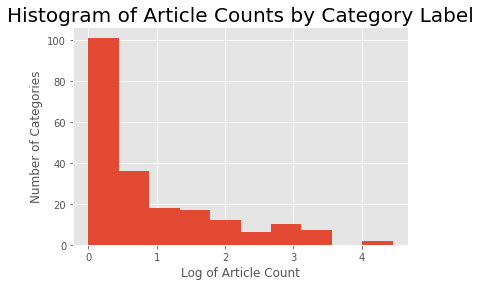

In [10]:
#histogram of category labels

plt.hist(np.log(y))
plt.xlabel('Log of Article Count')
plt.ylabel('Number of Categories')
plt.title('Histogram of Article Counts by Category Label', fontsize=20)
plt.show()

In [11]:
#initial string replacements to remove 'GMT+0000' and trim whitespace
df['datetime'] = df['datetime'].str.replace('+', '')
df['datetime'] = df['datetime'].str.replace('GMT0000', '').str.strip()

In [12]:
#set column entries to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], format="%a %b %d %Y %H:%M:%S")

#make new columns for day of week and day of year
df['day_of_week'] = df['datetime'].dt.dayofweek
df['day_of_year'] = df['datetime'].dt.dayofyear

In [13]:
#frequency distribution of article publication by day of the week

dayweek_dict = Counter(df.T.loc['day_of_week',])
lists = sorted(dayweek_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

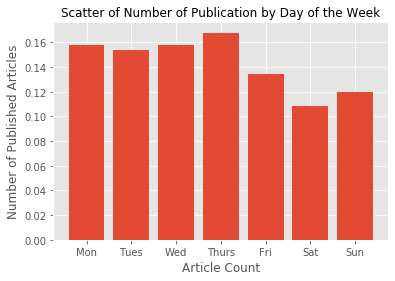

In [14]:
#histogram of distribution of article publication by day of the week

plt.bar(x,np.array(y)/sum(y))
plt.xlabel('Article Count')
plt.ylabel('Number of Published Articles')
plt.title('Scatter of Number of Publication by Day of the Week', fontsize=12)
plt.xticks(np.arange(7), ('Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun')) 
plt.show()

In [15]:
#frequency distribution of article publication by day of year

dayyear_dict = Counter(df.T.loc['day_of_year',])
lists = sorted(dayyear_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

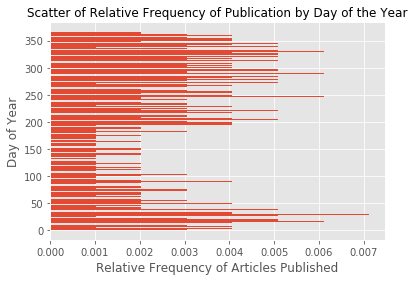

In [16]:
#histogram of frequency distribution of article publication by day of year

plt.barh(x,np.array(y)/sum(y), linewidth=0.00001)
plt.ylabel('Day of Year')
plt.xlabel('Relative Frequency of Articles Published')
plt.title('Scatter of Relative Frequency of Publication by Day of the Year', fontsize=12)
plt.show()

In [17]:
#preprocess captions to remove the text in brackets associated with photographer name and publisher
df['caption'] = df['caption'].apply(lambda x: re.sub('\[.*?([A-Za-z0-9_]+)\]', '', x))

In [18]:
#preprocess article to remove disclaimer statement at end
df['article'] = df['article'].apply(lambda x: re.sub("The views expressed in this article are the author's own and do not necessarily reflect Al Jazeera's editorial stance.", '', x))

In [19]:
#combine all article text and preprocess

df['total_text'] = df['title'] + ' ' + df['header'] + ' ' + df['caption'] + ' ' + df['article']

#convert all the string to lower cases
df['total_text'] = df['total_text'].str.lower()
# \s+ means all empty space (\n, \r, \t)
df['total_text'] = df['total_text'].apply(lambda x: re.sub('\s+', ' ', x))
#regex to remove special characters and numbers
df['total_text'] = df['total_text'].apply(lambda x: re.sub(r"[^a-zA-Z]+", ' ', x))
#remove possessives
df['total_text']=df['total_text'].str.replace(' s ', ' ')


#removes common articles from a corpus
stop = stopwords.words('english')
df['total_text'] = df['total_text'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))

In [20]:
#article word frequency distribution

word_dict = Counter(word_tokenize(df['total_text'].sum()))
lists = sorted(word_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

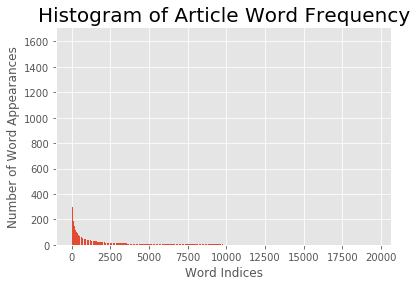

In [21]:
#histogram of article word frequency

plt.bar(np.arange(len(x)), np.array(sorted(y))[::-1], linewidth=0.0000001)
plt.xlabel('Word Indices')
plt.ylabel('Number of Word Appearances')
plt.title('Histogram of Article Word Frequency', fontsize=20)
plt.show()

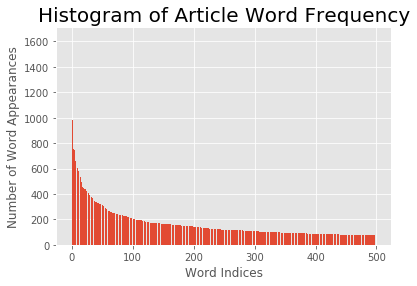

In [22]:
#article word frequency distribution for most frequent 500 words

plt.bar(np.arange(500), np.array(sorted(y))[::-1][:500], linewidth=0.0000001)
plt.xlabel('Word Indices')
plt.ylabel('Number of Word Appearances')
plt.title('Histogram of Article Word Frequency', fontsize=20)
plt.show()

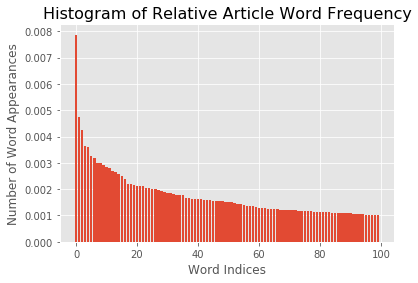

In [23]:
#relative article word frequency distribution for the most frequent 100 words

s=np.array(sorted(y))[::-1].sum()
plt.bar(np.arange(100), np.array(sorted(y))[::-1][:100]/s, linewidth=0.0000001)
plt.xlabel('Word Indices')
plt.ylabel('Number of Word Appearances')
plt.title('Histogram of Relative Article Word Frequency', fontsize=16)
plt.show()

In [24]:
#character frequency distribution between all articles

char_dict = Counter(df['total_text'].sum().replace(" ", ""))
lists = sorted(char_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

array([0.08913336, 0.01370866, 0.0406686 , 0.03832326, 0.1169553 ,
       0.01301069, 0.0241175 , 0.02057057, 0.08949752, 0.0029082 ,
       0.00837346, 0.0508484 , 0.0322489 , 0.07496301, 0.06169871,
       0.02947004, 0.00139955, 0.07337704, 0.07225711, 0.07151796,
       0.03236523, 0.01126432, 0.01086115, 0.00233307, 0.01634952,
       0.00177888])

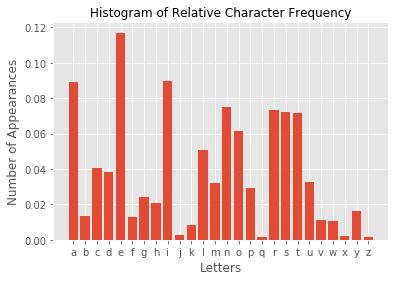

In [25]:
#character frequency distribution between all articles

plt.bar(x, np.array(y)/sum(y))
plt.xlabel('Letters')
plt.ylabel('Number of Appearances')
plt.title('Histogram of Relative Character Frequency', fontsize=12)
plt.show()

In [26]:
#preprocess titles

#convert all the string to lower cases
df['title'] = df['title'].str.lower()
# \s+ means all empty space (\n, \r, \t)
df['title'] = df['title'].apply(lambda x: re.sub('\s+', ' ', x))
#regex to remove special characters and numbers
df['title'] = df['title'].apply(lambda x: re.sub(r"[^a-zA-Z]+", ' ', x))
#remove possessives
df['title']=df['title'].str.replace(' s ', ' ')

#removes common articles from a corpus
stop = stopwords.words('english')
df['title'] = df['title'].apply(lambda text: " ".join(word for word in text.split() if word not in stop))

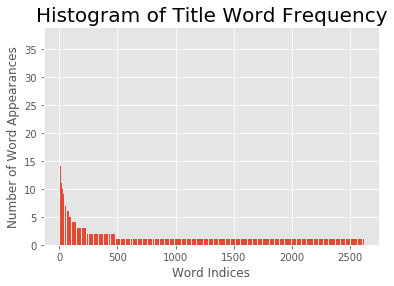

In [27]:
#title word frequency distribution

title_dict = Counter(word_tokenize(df['title'].sum()))
lists = sorted(title_dict.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.bar(np.arange(len(x)), np.array(sorted(y))[::-1], linewidth=0.01)
plt.xlabel('Word Indices')
plt.ylabel('Number of Word Appearances')
plt.title('Histogram of Title Word Frequency', fontsize=20)
plt.show()

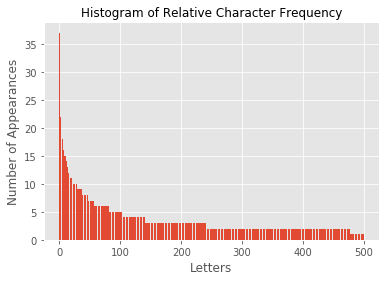

In [28]:
#title word frequency distribution of most frequent five-hundred

plt.bar(np.arange(500), np.array(sorted(y))[::-1][:500], linewidth=0.01)
plt.xlabel('Letters')
plt.ylabel('Number of Appearances')
plt.title('Histogram of Relative Character Frequency', fontsize=12)
plt.show()

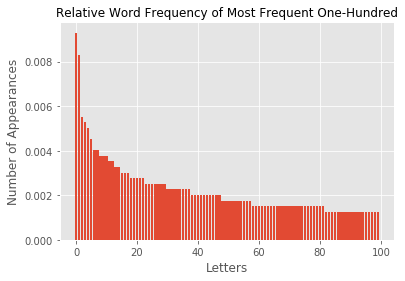

In [29]:
#title word frequency distribution of most frequent one-hundred

s=np.array(sorted(y))[::-1].sum()
plt.bar(np.arange(100), np.array(sorted(y))[::-1][:100]/s, linewidth=0.01)
plt.xlabel('Letters')
plt.ylabel('Number of Appearances')
plt.title('Relative Word Frequency of Most Frequent One-Hundred', fontsize=12)
plt.show()